In [1]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd
!pip install split-folders

In [2]:
path="/kaggle/input/combined-project-data/Data"

In [3]:
import splitfolders
splitfolders.ratio(path, output="/kaggle/working/", 
                   seed=1, ratio=(.8,.2), 
                   group_prefix=None,)

Copying files: 900 files [00:06, 134.54 files/s]


In [4]:
class_labels=['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma']

In [5]:
def prepare_name_with_labels(folder_name,Y, dataset_type='train'):
    """ Prepare the file names (X) and the class labels (Y) from folder location of images.

        Args:
            folder_name: str
                Source folder's path

    """
#     Y=[]
    source_files = os.listdir(os.path.join("/kaggle/working/", dataset_type, folder_name))
    y_label = 0
    for i in range(len(class_labels)):
        if(folder_name == class_labels[i]):
            y_label = i
    for val in source_files:
        Y.append(y_label)

In [6]:
def load_images_from_folder(X,folder,size=(224,224)):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img=cv2.resize(img,size)
            X.append(img)
    print(len(X))

In [7]:
X=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/train/"+class_labels[i])
    load_images_from_folder(X,folder)
#     X.append(image)
    print("\n",i)

260

 0
390

 1
517

 2
718

 3


In [8]:
Y=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y)
    print(i)

0
1
2
3


In [9]:
X_test=[]
for i in range(len(class_labels)):
    folder=os.path.join("/kaggle/working/val/"+class_labels[i])
    load_images_from_folder(X_test,folder)
#     X.append(image)
    print("\n",i)

66

 0
99

 1
131

 2
182

 3


In [10]:
Y_test=[]
for i in range(len(class_labels)):
    prepare_name_with_labels(class_labels[i],Y_test,dataset_type='val')
    print(i)

0
1
2
3


In [11]:
X = np.asarray(X)
Y = np.asarray(Y)
X_test=np.asarray(X_test)
Y_test=np.asarray(Y_test)
print(X.shape)
print(Y.shape)
print(X_test.shape)
print(Y_test.shape)

(718, 224, 224, 3)
(718,)
(182, 224, 224, 3)
(182,)


In [12]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc = OneHotEncoder().fit(Y.reshape(-1,1))
Y_label=drop_binary_enc.transform(Y.reshape(-1,1)).toarray()
print(Y_label.shape)

(718, 4)


In [13]:
from sklearn.preprocessing import OneHotEncoder
drop_binary_enc_test = OneHotEncoder().fit(Y_test.reshape(-1,1))
Y_label_test=drop_binary_enc_test.transform(Y_test.reshape(-1,1)).toarray()
print(Y_label_test.shape)

(182, 4)


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
valid_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')
test_datagen = ImageDataGenerator(rescale=1./255, dtype='float32')

In [15]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

In [16]:
image_shape = (224,224,3)
N_CLASSES = 4
BATCH_SIZE = 32
vgg16_model = tf.keras.applications.VGG16(include_top=False, input_shape=image_shape, weights="imagenet", classes=4)
    # Freeze the pretrained weights
vgg16_model.trainable =False

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
early_stopping = EarlyStopping(verbose=1, patience=12)

In [18]:
def create_new_model(n):
    n=str(n)
    model = Sequential()
    model.add(vgg16_model)
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(N_CLASSES, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate= 0.001, decay= 1e-5), loss = 'categorical_crossentropy', metrics = ['acc'])
    
    checkpointer = ModelCheckpoint(filepath='./vgg16_model'+n+'.hdf5',
                            monitor='val_acc', verbose = 1,
                            save_best_only=True)
    return model,checkpointer
#     "model"+n.summary()

Results for fold 1
Epoch 1/25


2023-04-18 06:59:14.467104: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0988 - acc: 0.6098
Epoch 1: val_acc improved from -inf to 0.48611, saving model to ./vgg16_model1.hdf5
18/18 [==============================] - 15s 391ms/step - loss: 1.0988 - acc: 0.6098 - val_loss: 1.0072 - val_acc: 0.4861
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2698 - acc: 0.8868
Epoch 2: val_acc improved from 0.48611 to 0.52083, saving model to ./vgg16_model1.hdf5
18/18 [==============================] - 2s 114ms/step - loss: 0.2698 - acc: 0.8868 - val_loss: 1.0795 - val_acc: 0.5208
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1017 - acc: 0.9774
Epoch 3: val_acc improved from 0.52083 to 0.56944, saving model to ./vgg16_model1.hdf5
18/18 [==============================] - 2s 114ms/step - loss: 0.1017 - acc: 0.9774 - val_loss: 0.9070 - val_acc: 0.5694
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0714 - acc: 0.9774
Epoch 4: val_acc improved from 0.

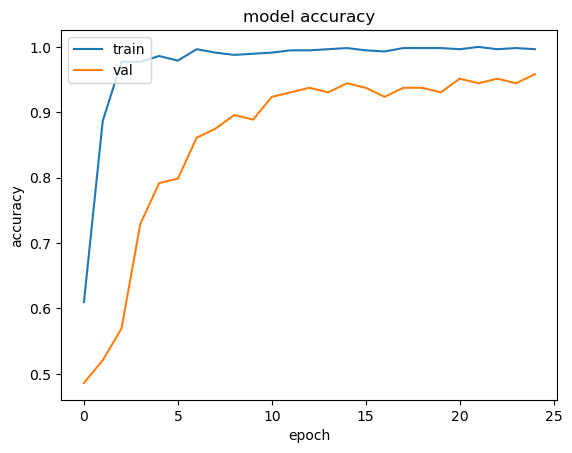

Model metrics for Round 1

6/6 [==============================] - 3s 502ms/step - loss: 0.2113 - acc: 0.9451
Accuracy 94.50549483299255
Loss 0.21128004789352417
Results for fold 2
Epoch 1/25
 1/18 [>.............................] - ETA: 15s - loss: 1.9350 - acc: 0.2812

2023-04-18 07:00:22.175183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0775 - acc: 0.6150
Epoch 1: val_acc improved from -inf to 0.49306, saving model to ./vgg16_model2.hdf5
18/18 [==============================] - 3s 131ms/step - loss: 1.0775 - acc: 0.6150 - val_loss: 1.0036 - val_acc: 0.4931
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2558 - acc: 0.9007
Epoch 2: val_acc did not improve from 0.49306
18/18 [==============================] - 2s 104ms/step - loss: 0.2558 - acc: 0.9007 - val_loss: 0.9294 - val_acc: 0.4931
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1306 - acc: 0.9530
Epoch 3: val_acc improved from 0.49306 to 0.73611, saving model to ./vgg16_model2.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.1306 - acc: 0.9530 - val_loss: 0.6180 - val_acc: 0.7361
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0730 - acc: 0.9756
Epoch 4: val_acc improved from 0.73611 to 0.74306, saving model to ./vgg16_

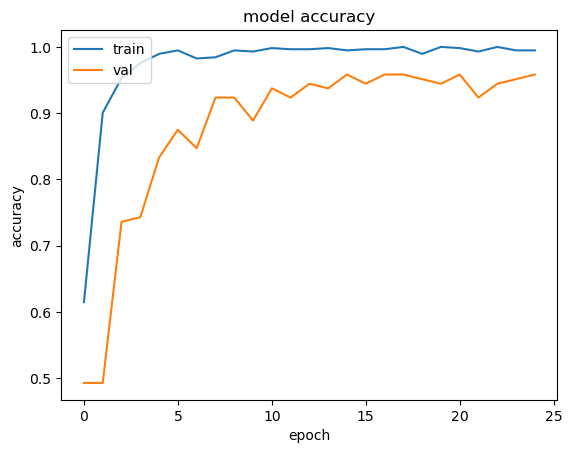

Model metrics for Round 2

6/6 [==============================] - 0s 70ms/step - loss: 0.2644 - acc: 0.9505
Accuracy 95.05494236946106
Loss 0.26441287994384766
Results for fold 3
Epoch 1/25
 1/18 [>.............................] - ETA: 15s - loss: 2.0128 - acc: 0.2500

2023-04-18 07:01:14.017296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0117 - acc: 0.6132
Epoch 1: val_acc improved from -inf to 0.65972, saving model to ./vgg16_model3.hdf5
18/18 [==============================] - 3s 125ms/step - loss: 1.0117 - acc: 0.6132 - val_loss: 0.7371 - val_acc: 0.6597
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2718 - acc: 0.9077
Epoch 2: val_acc improved from 0.65972 to 0.70833, saving model to ./vgg16_model3.hdf5
18/18 [==============================] - 2s 112ms/step - loss: 0.2718 - acc: 0.9077 - val_loss: 0.8058 - val_acc: 0.7083
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1605 - acc: 0.9460
Epoch 3: val_acc improved from 0.70833 to 0.73611, saving model to ./vgg16_model3.hdf5
18/18 [==============================] - 2s 112ms/step - loss: 0.1605 - acc: 0.9460 - val_loss: 0.7585 - val_acc: 0.7361
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0898 - acc: 0.9652
Epoch 4: val_acc improved from 0.7

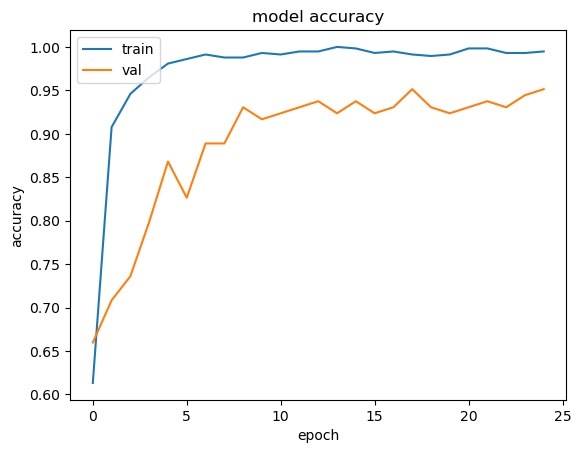

Model metrics for Round 3

6/6 [==============================] - 1s 70ms/step - loss: 0.4096 - acc: 0.9451
Accuracy 94.50549483299255
Loss 0.4096498489379883
Results for fold 4
Epoch 1/25
 1/18 [>.............................] - ETA: 16s - loss: 1.7652 - acc: 0.3125

2023-04-18 07:02:05.888765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.9860 - acc: 0.6470
Epoch 1: val_acc improved from -inf to 0.69231, saving model to ./vgg16_model4.hdf5
18/18 [==============================] - 8s 387ms/step - loss: 0.9860 - acc: 0.6470 - val_loss: 0.7124 - val_acc: 0.6923
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2780 - acc: 0.9078
Epoch 2: val_acc improved from 0.69231 to 0.74126, saving model to ./vgg16_model4.hdf5
18/18 [==============================] - 2s 114ms/step - loss: 0.2780 - acc: 0.9078 - val_loss: 0.6070 - val_acc: 0.7413
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1192 - acc: 0.9600
Epoch 3: val_acc improved from 0.74126 to 0.82517, saving model to ./vgg16_model4.hdf5
18/18 [==============================] - 2s 111ms/step - loss: 0.1192 - acc: 0.9600 - val_loss: 0.4887 - val_acc: 0.8252
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0951 - acc: 0.9739
Epoch 4: val_acc improved from 0.8

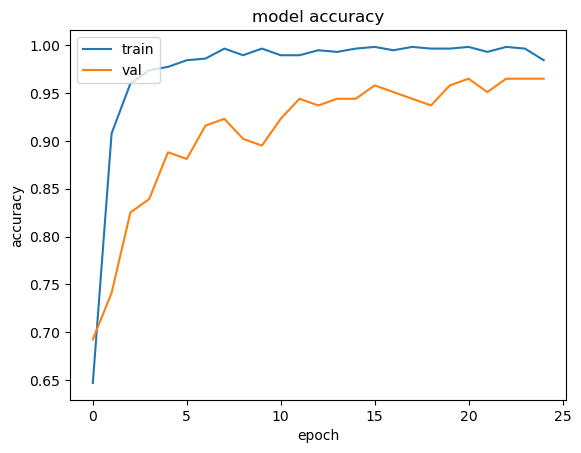

Model metrics for Round 4

6/6 [==============================] - 0s 71ms/step - loss: 0.2825 - acc: 0.9451
Accuracy 94.50549483299255
Loss 0.2825039327144623
Results for fold 5
Epoch 1/25
 1/18 [>.............................] - ETA: 16s - loss: 2.1396 - acc: 0.1875

2023-04-18 07:03:02.693816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.9884 - acc: 0.6261
Epoch 1: val_acc improved from -inf to 0.44755, saving model to ./vgg16_model5.hdf5
18/18 [==============================] - 3s 125ms/step - loss: 0.9884 - acc: 0.6261 - val_loss: 1.3312 - val_acc: 0.4476
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2698 - acc: 0.9026
Epoch 2: val_acc improved from 0.44755 to 0.53147, saving model to ./vgg16_model5.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.2698 - acc: 0.9026 - val_loss: 1.0658 - val_acc: 0.5315
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1522 - acc: 0.9391
Epoch 3: val_acc improved from 0.53147 to 0.61538, saving model to ./vgg16_model5.hdf5
18/18 [==============================] - 2s 116ms/step - loss: 0.1522 - acc: 0.9391 - val_loss: 0.8598 - val_acc: 0.6154
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0917 - acc: 0.9600
Epoch 4: val_acc improved from 0.6

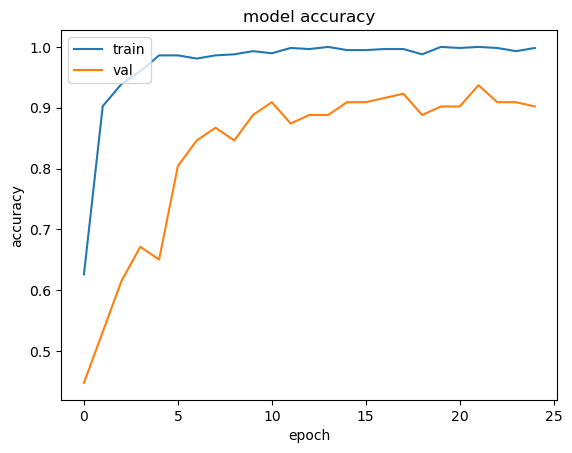

Model metrics for Round 5

6/6 [==============================] - 0s 70ms/step - loss: 0.2877 - acc: 0.9451
Accuracy 94.50549483299255
Loss 0.28774282336235046


In [19]:
fold_num = 0
skf_acc=[]
skf_loss=[]
for train_index, val_index in kfold.split(X, Y):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy",result[1]*100)
    print("Loss",result[0])
    skf_acc.append(result[1])
    skf_loss.append(result[0])

In [20]:
from sklearn.metrics import classification_report
target_names=class_labels
model2=tf.keras.models.load_model("/kaggle/working/vgg16_model5.hdf5")


In [21]:
model2.evaluate(test_generator)

6/6 [==============================] - 1s 71ms/step - loss: 0.2226 - acc: 0.9560


[0.22264352440834045, 0.9560439586639404]

In [22]:
from sklearn.model_selection import train_test_split
X_train_,X_val_,Y_train_,Y_val_=train_test_split(X,Y_label,train_size=0.8, random_state=1)

In [23]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(574, 224, 224, 3) (574, 4)
(144, 224, 224, 3) (144, 4)


Epoch 1/25
 1/18 [>.............................] - ETA: 16s - loss: 1.8005 - acc: 0.2188

2023-04-18 07:04:32.133303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0355 - acc: 0.6150
Epoch 1: val_acc improved from -inf to 0.65278, saving model to ./vgg16_modelx.hdf5
18/18 [==============================] - 3s 130ms/step - loss: 1.0355 - acc: 0.6150 - val_loss: 0.7273 - val_acc: 0.6528
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2558 - acc: 0.8955
Epoch 2: val_acc improved from 0.65278 to 0.72222, saving model to ./vgg16_modelx.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.2558 - acc: 0.8955 - val_loss: 0.7033 - val_acc: 0.7222
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1501 - acc: 0.9530
Epoch 3: val_acc did not improve from 0.72222
18/18 [==============================] - 2s 104ms/step - loss: 0.1501 - acc: 0.9530 - val_loss: 0.7334 - val_acc: 0.7014
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0962 - acc: 0.9669
Epoch 4: val_acc improved from 0.72222 to 0.81944, saving model to ./vgg16_

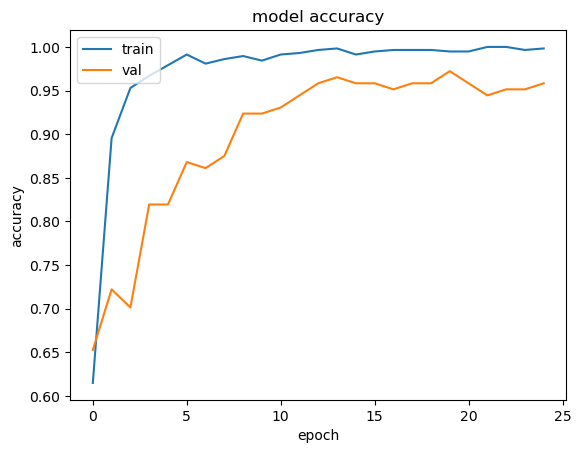

In [25]:
train_generator = train_datagen.flow(X_train_,
                                         Y_train_,
                                         batch_size = BATCH_SIZE)
valid_generator = valid_datagen.flow(X_val_,
                                     Y_val_,
                                     batch_size = BATCH_SIZE)
test_generator = test_datagen.flow(X_test,
                                   Y_label_test,
                                   batch_size = BATCH_SIZE)
#create a new model
model,checkpointer=create_new_model('x')
# fit model
history= model.fit(train_generator,
                        epochs = 25,
                        verbose = 1,
                        validation_data = valid_generator,
                        callbacks = [checkpointer, early_stopping])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [26]:
score=model.evaluate(test_generator)
print("Accuracy",score[1]*100)
print("Loss",score[0])

6/6 [==============================] - 1s 73ms/step - loss: 0.2273 - acc: 0.9670
Accuracy 96.70329689979553
Loss 0.22726482152938843


K Fold Cross Validation

In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1)

Results for fold 1.1
Epoch 1/25
 1/18 [>.............................] - ETA: 15s - loss: 1.6131 - acc: 0.3438

2023-04-18 07:05:34.920844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0608 - acc: 0.5976
Epoch 1: val_acc improved from -inf to 0.72222, saving model to ./vgg16_model1.1.hdf5
18/18 [==============================] - 3s 125ms/step - loss: 1.0608 - acc: 0.5976 - val_loss: 0.6458 - val_acc: 0.7222
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2536 - acc: 0.9094
Epoch 2: val_acc improved from 0.72222 to 0.77778, saving model to ./vgg16_model1.1.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.2536 - acc: 0.9094 - val_loss: 0.5751 - val_acc: 0.7778
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1130 - acc: 0.9582
Epoch 3: val_acc improved from 0.77778 to 0.83333, saving model to ./vgg16_model1.1.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.1130 - acc: 0.9582 - val_loss: 0.3780 - val_acc: 0.8333
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0856 - acc: 0.9774
Epoch 4: val_acc improved fr

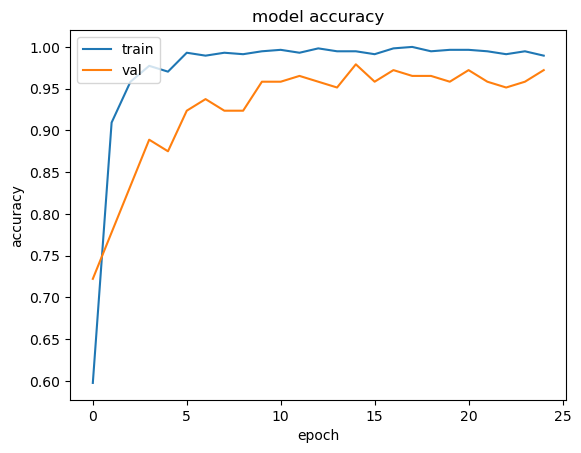

Model metrics for Round 1.1

6/6 [==============================] - 0s 69ms/step - loss: 0.2677 - acc: 0.9505
Accuracy:  95.05494236946106
Loss:  0.2677488327026367
Results for fold 2.1
Epoch 1/25
 1/18 [>.............................] - ETA: 15s - loss: 1.9690 - acc: 0.0938

2023-04-18 07:06:27.877253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0674 - acc: 0.5801
Epoch 1: val_acc improved from -inf to 0.54861, saving model to ./vgg16_model2.1.hdf5
18/18 [==============================] - 3s 129ms/step - loss: 1.0674 - acc: 0.5801 - val_loss: 0.9113 - val_acc: 0.5486
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2817 - acc: 0.8937
Epoch 2: val_acc improved from 0.54861 to 0.72222, saving model to ./vgg16_model2.1.hdf5
18/18 [==============================] - 2s 113ms/step - loss: 0.2817 - acc: 0.8937 - val_loss: 0.6834 - val_acc: 0.7222
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1096 - acc: 0.9582
Epoch 3: val_acc did not improve from 0.72222
18/18 [==============================] - 2s 103ms/step - loss: 0.1096 - acc: 0.9582 - val_loss: 0.6771 - val_acc: 0.7153
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.9756
Epoch 4: val_acc improved from 0.72222 to 0.75000, saving model to ./vg

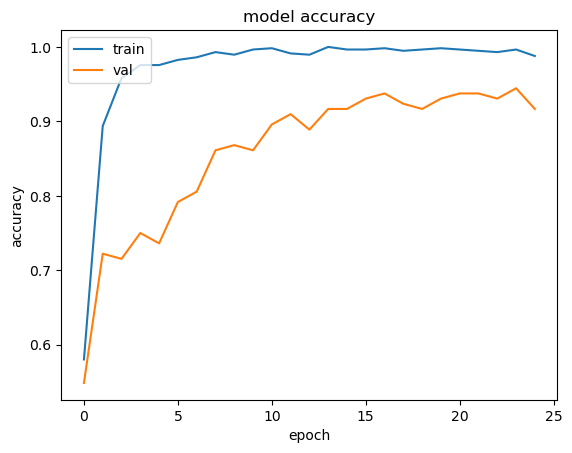

Model metrics for Round 2.1

6/6 [==============================] - 1s 73ms/step - loss: 0.3110 - acc: 0.9396
Accuracy:  93.95604133605957
Loss:  0.31102341413497925
Results for fold 3.1
Epoch 1/25
 1/18 [>.............................] - ETA: 15s - loss: 2.3092 - acc: 0.1875

2023-04-18 07:07:20.012937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.1245 - acc: 0.5941
Epoch 1: val_acc improved from -inf to 0.66667, saving model to ./vgg16_model3.1.hdf5
18/18 [==============================] - 3s 127ms/step - loss: 1.1245 - acc: 0.5941 - val_loss: 0.7244 - val_acc: 0.6667
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2184 - acc: 0.9321
Epoch 2: val_acc improved from 0.66667 to 0.71528, saving model to ./vgg16_model3.1.hdf5
18/18 [==============================] - 2s 111ms/step - loss: 0.2184 - acc: 0.9321 - val_loss: 0.6717 - val_acc: 0.7153
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1375 - acc: 0.9599
Epoch 3: val_acc improved from 0.71528 to 0.84028, saving model to ./vgg16_model3.1.hdf5
18/18 [==============================] - 2s 112ms/step - loss: 0.1375 - acc: 0.9599 - val_loss: 0.4910 - val_acc: 0.8403
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0715 - acc: 0.9739
Epoch 4: val_acc improved fr

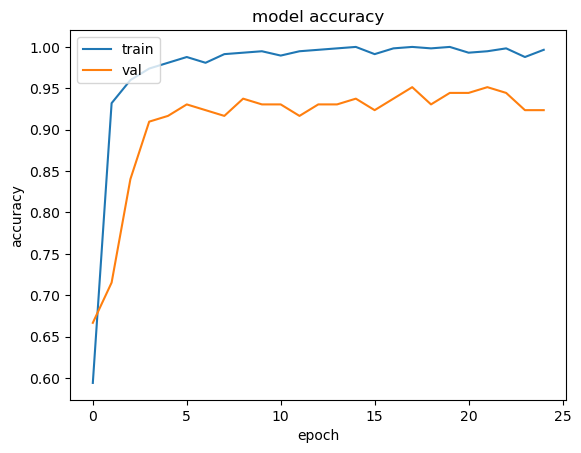

Model metrics for Round 3.1

6/6 [==============================] - 0s 68ms/step - loss: 0.2059 - acc: 0.9451
Accuracy:  94.50549483299255
Loss:  0.20594896376132965
Results for fold 4.1
Epoch 1/25


2023-04-18 07:08:12.123549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 0.9945 - acc: 0.6278
Epoch 1: val_acc improved from -inf to 0.71329, saving model to ./vgg16_model4.1.hdf5
18/18 [==============================] - 3s 124ms/step - loss: 0.9945 - acc: 0.6278 - val_loss: 0.7258 - val_acc: 0.7133
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2770 - acc: 0.8904
Epoch 2: val_acc improved from 0.71329 to 0.79021, saving model to ./vgg16_model4.1.hdf5
18/18 [==============================] - 2s 111ms/step - loss: 0.2770 - acc: 0.8904 - val_loss: 0.6486 - val_acc: 0.7902
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1319 - acc: 0.9461
Epoch 3: val_acc did not improve from 0.79021
18/18 [==============================] - 2s 104ms/step - loss: 0.1319 - acc: 0.9461 - val_loss: 0.5632 - val_acc: 0.7762
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0849 - acc: 0.9739
Epoch 4: val_acc improved from 0.79021 to 0.80420, saving model to ./vg

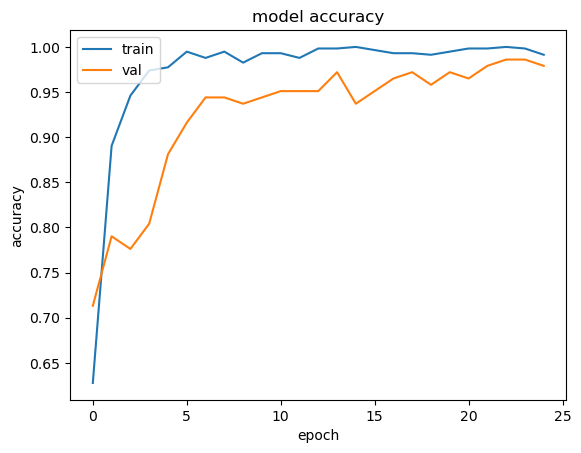

Model metrics for Round 4.1

6/6 [==============================] - 0s 69ms/step - loss: 0.1844 - acc: 0.9725
Accuracy:  97.25274443626404
Loss:  0.18438014388084412
Results for fold 5.1
Epoch 1/25


2023-04-18 07:09:03.640781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - ETA: 0s - loss: 1.0191 - acc: 0.6157
Epoch 1: val_acc improved from -inf to 0.53147, saving model to ./vgg16_model5.1.hdf5
18/18 [==============================] - 3s 124ms/step - loss: 1.0191 - acc: 0.6157 - val_loss: 0.9101 - val_acc: 0.5315
Epoch 2/25
18/18 [==============================] - ETA: 0s - loss: 0.2408 - acc: 0.9078
Epoch 2: val_acc improved from 0.53147 to 0.76224, saving model to ./vgg16_model5.1.hdf5
18/18 [==============================] - 2s 112ms/step - loss: 0.2408 - acc: 0.9078 - val_loss: 0.6360 - val_acc: 0.7622
Epoch 3/25
18/18 [==============================] - ETA: 0s - loss: 0.1447 - acc: 0.9496
Epoch 3: val_acc improved from 0.76224 to 0.77622, saving model to ./vgg16_model5.1.hdf5
18/18 [==============================] - 2s 114ms/step - loss: 0.1447 - acc: 0.9496 - val_loss: 0.5703 - val_acc: 0.7762
Epoch 4/25
18/18 [==============================] - ETA: 0s - loss: 0.0790 - acc: 0.9791
Epoch 4: val_acc did not imp

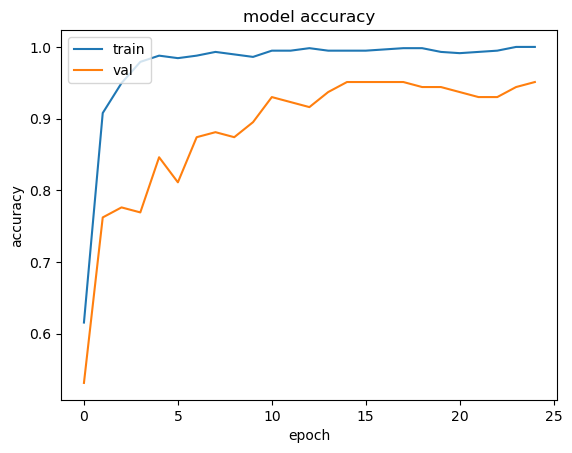

Model metrics for Round 5.1

6/6 [==============================] - 0s 68ms/step - loss: 0.2264 - acc: 0.9341
Accuracy:  93.40659379959106
Loss:  0.22640374302864075


In [28]:
fold_num = 0.1
kf_acc=[]
kf_loss=[]
for train_index, val_index in kf.split(X, Y_label):
    # First cut all images from validation to train (if any exists)
#     transfer_all_class_between_folders('validation', 'train', 1.0)
    fold_num += 1
    print("Results for fold", fold_num)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y_label[train_index], Y_label[val_index]
#     print("\n",X_train.shape,Y_train.shape)
#     print(X_val.shape,Y_val.shape)
    train_generator = train_datagen.flow(X_train,
                                         Y_train,
                                         batch_size = BATCH_SIZE)
    valid_generator = valid_datagen.flow(X_val,
                                         Y_val,
                                         batch_size = BATCH_SIZE)
    test_generator = test_datagen.flow(X_test,
                                       Y_label_test,
                                       batch_size = BATCH_SIZE)

    model,checkpointer=create_new_model(fold_num)
    # fit model
    history= model.fit(train_generator,
                            epochs = 25,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("Model metrics for Round "+str(fold_num)+"\n")
    result=model.evaluate(test_generator)
    print("Accuracy: ",result[1]*100)
    print("Loss: ",result[0])
    kf_acc.append(result[1])
    kf_loss.append(result[0])

In [29]:
skf_acc=np.array(skf_acc)
skf_loss=np.array(skf_loss)
kf_acc=np.array(kf_acc)
kf_loss=np.array(kf_loss)

print("Accuracy and loss for StratifiedKfold")
print("Accuracy: ",sum(skf_acc)/len(skf_acc)*100)
print("Loss: ",sum(skf_loss)/len(skf_loss))
print("\nAccuracy and loss for Kfold")
print("Accuracy: ",sum(kf_acc)/len(kf_acc)*100)
print("Loss: ",sum(kf_loss)/len(kf_loss))
print("\nAccuracy and loss for Holdout")
print("Accuracy: ",score[1]*100)
print("Loss: ",score[0])

Accuracy and loss for StratifiedKfold
Accuracy:  94.61538434028625
Loss:  0.29111790657043457

Accuracy and loss for Kfold
Accuracy:  94.83516335487366
Loss:  0.2391010195016861

Accuracy and loss for Holdout
Accuracy:  96.70329689979553
Loss:  0.22726482152938843
